In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib as mpl
import seaborn as sns
import datetime as dt

# Import Sparksession
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

# Import Time Series Forecasting
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

spark = SparkSession.builder.appName("Sales Forecasting")\
        .config("spark.memory.offHeap.enabled","true")\
        .config("spark.memory.offHeap.size","10g")\
        .getOrCreate()

spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [5]:
# Define the path to the folder
folder_path = "Dataset/Cleaned"

# Load all CSV files in the folder
data = spark.read.format('csv').option('header','true').option('inferSchema','true').load(folder_path)

# Preprocessing data in accordance with the previous explanation.
data = (data
        .withColumn("Date Order was placed", to_date(col("Date Order was placed")))
        .withColumn("Delivery Date", to_date(col("Delivery Date")))
)

data.show(10)

+-----------+---------------+---------------------+-------------+---------+------------+----------------+---------------------------------+-------------------+----+-----+------------+------+
|Customer ID|Customer Status|Date Order was placed|Delivery Date| Order ID|  Product ID|Quantity Ordered|Total Retail Price for This Order|Cost Price Per Unit|Year|Month|Retail Price|Profit|
+-----------+---------------+---------------------+-------------+---------+------------+----------------+---------------------------------+-------------------+----+-----+------------+------+
|        579|         Silver|           2017-01-01|   2017-01-07|123002578|220101400106|               2|                             92.6|               20.7|2017|    1|        46.3|  51.2|
|       7574|         Silver|           2017-01-01|   2017-01-05|123004074|210201000009|               1|                             21.7|               9.95|2017|    1|        21.7| 11.75|
|      28861|           Gold|           2017-

In [6]:
# Load product_supplier data from directory and print the shape
product_df = spark.read.csv('Dataset/product_supplier.csv',
                    header=True,
                    inferSchema=True,
                    escape="\"")

product_df.show(5)

+------------+------------+-----------------+--------------------+--------------------+----------------+--------------------+-----------+
|  Product ID|Product Line| Product Category|       Product Group|        Product Name|Supplier Country|       Supplier Name|Supplier ID|
+------------+------------+-----------------+--------------------+--------------------+----------------+--------------------+-----------+
|210100100001|    Children|Children Outdoors|Outdoor things, Kids|Boy's and Girl's ...|              NO|Scandinavian Clot...|         50|
|210100100002|    Children|Children Outdoors|Outdoor things, Kids|   Children's Jacket|              ES| Luna sastreria S.A.|       4742|
|210100100003|    Children|Children Outdoors|Outdoor things, Kids|Children's Jacket...|              NO|Scandinavian Clot...|         50|
|210100100004|    Children|Children Outdoors|Outdoor things, Kids| Children's Rain Set|              NO|Scandinavian Clot...|         50|
|210100100005|    Children|Childre

In [7]:
df_merge = data.join(product_df, 'Product ID', 'inner')

df_merge.show()

+------------+-----------+---------------+---------------------+-------------+---------+----------------+---------------------------------+-------------------+----+-----+------------+------+---------------+--------------------+--------------------+--------------------+----------------+--------------------+-----------+
|  Product ID|Customer ID|Customer Status|Date Order was placed|Delivery Date| Order ID|Quantity Ordered|Total Retail Price for This Order|Cost Price Per Unit|Year|Month|Retail Price|Profit|   Product Line|    Product Category|       Product Group|        Product Name|Supplier Country|       Supplier Name|Supplier ID|
+------------+-----------+---------------+---------------------+-------------+---------+----------------+---------------------------------+-------------------+----+-----+------------+------+---------------+--------------------+--------------------+--------------------+----------------+--------------------+-----------+
|220101400106|        579|         Silve

### Total Sales Forecasting

In [30]:
ts_forecast = (df_merge.groupby("Date Order was placed")
               .agg(round(sum('Total Retail Price for This Order'),2).alias('y'))
               .sort(col("Date Order was placed"))
               .withColumnRenamed("Date Order was placed", "ds")
)

ts_forecast.show(5)

+----------+-------+
|        ds|      y|
+----------+-------+
|2017-01-01|  225.5|
|2017-01-02|10476.3|
|2017-01-03| 8683.2|
|2017-01-04|3434.19|
|2017-01-05| 9129.8|
+----------+-------+
only showing top 5 rows



In [31]:
fig_1 = px.line(ts_forecast.toPandas(), x='ds', y='y', title='Total Sales')
fig_1.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='2y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward")
        ])
    )
)
fig_1.show()

In [40]:
sales_data = ts_forecast.toPandas()

model = Prophet(seasonality_mode= 'multiplicative', weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=True)
model.fit(sales_data)

12:09:33 - cmdstanpy - INFO - Chain [1] start processing
12:09:33 - cmdstanpy - INFO - Chain [1] done processing


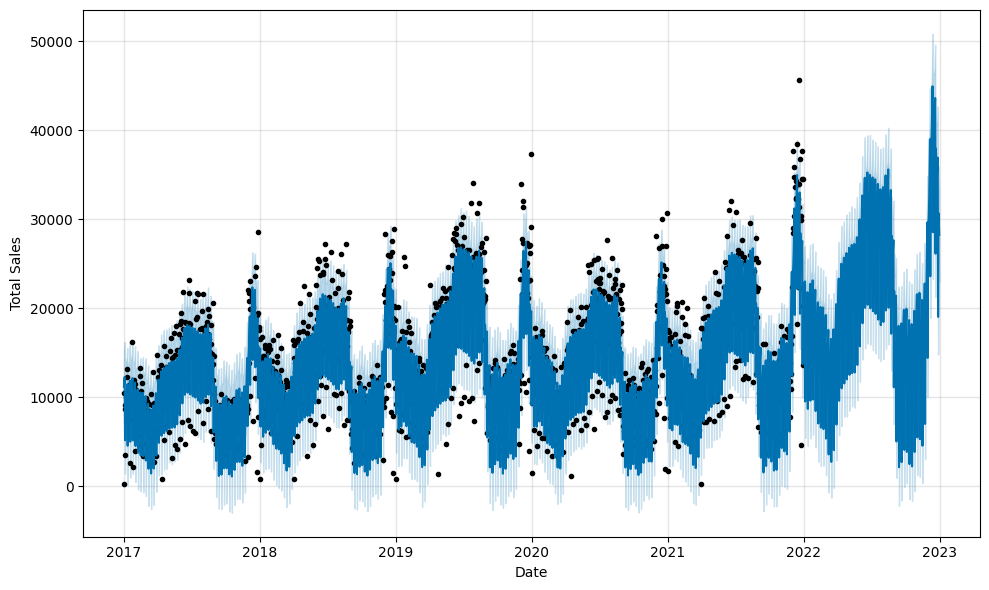

In [65]:
# predicting out of sample for next year
future = model.make_future_dataframe(periods=365, freq='d', include_history=True)
future.tail()

sales_forecast = model.predict(future)
f_pd = sales_forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].set_index('ds')
st_pd = sales_data[['ds', 'y']].set_index('ds')
sales_forecast_actual = f_pd.join(st_pd, how='left')

fig_2 = model.plot(sales_forecast, xlabel="Date", ylabel="Total Sales", figsize=(10,6))

In [67]:
# Create a line plot
fig_3 = px.line(sales_forecast_actual, x=sales_forecast_actual.index, y=['y', 'yhat'], title='Total Sales Forecast Comparison')
 
fig_3.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='2y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward")
        ])
    )
)

# Update the legend items
fig_3.for_each_trace(lambda trace: trace.update(name = 'Actual' if trace.name == 'y' else 'Forecast'))

# Show the plot
fig_3.show()

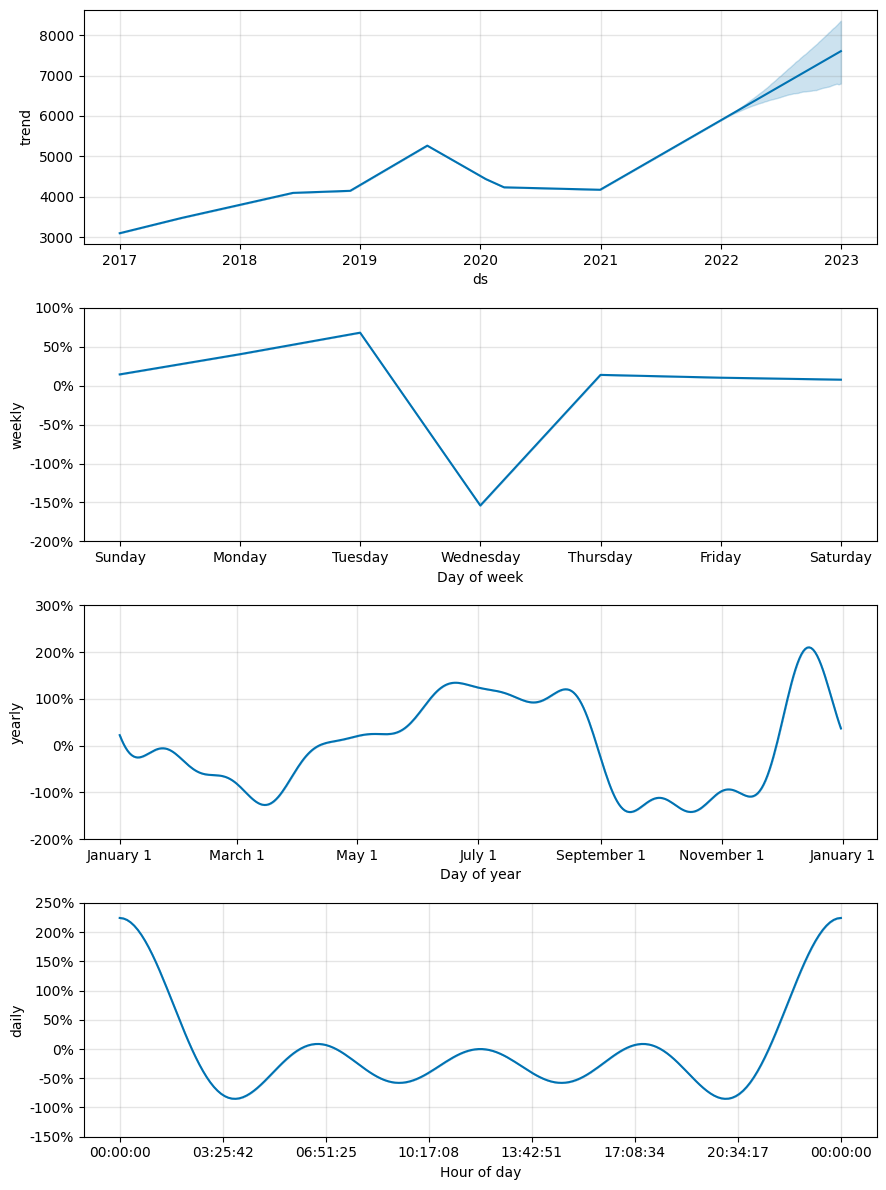

In [69]:
comp = model.plot_components(sales_forecast)

### Anomaly and outlier detection

In [70]:
sales_forecast_actual['error'] = sales_forecast_actual['y'] - sales_forecast_actual['yhat']
sales_forecast_actual['uncertainty'] = sales_forecast_actual['yhat_upper'] - sales_forecast_actual['yhat_lower']

sales_forecast_actual['anomaly'] = np.where((np.abs(sales_forecast_actual['error']) > 1.5*sales_forecast_actual['uncertainty']), 'Yes', 'No')

In [72]:
sales_forecast_actual['anomaly'].value_counts()

anomaly
No     2178
Yes      13
Name: count, dtype: int64

In [74]:
#visualize the anomaly data
fig = px.scatter(sales_forecast_actual.reset_index(), x='ds', y='y', color='anomaly', title='Total Sales Forecast Anomaly')
#slider
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='3y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward"),
              dict(step="all")
        ])
    )
)
fig.show()

### Evaluate forecast model

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/16 [00:00<?, ?it/s]12:59:44 - cmdstanpy - INFO - Chain [1] start processing
12:59:44 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:00<00:01,  9.17it/s]12:59:44 - cmdstanpy - INFO - Chain [1] start processing
12:59:45 - cmdstanpy - INFO - Chain [1] done processing
12:59:45 - cmdstanpy - INFO - Chain [1] start processing
12:59:45 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:00<00:01, 10.14it/s]12:59:45 - cmdstanpy - INFO - Chain [1] start processing
12:59:45 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 4/16 [00:00<00:01,  9.58it/s]12:59:45 - cmdstanpy - INFO - Chain [1] start processing
12:59:45 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 5/16 [00:00<00:01,  9.28it/s]12:59:45 - cmdstanpy - INFO - Chain [1] start processing
12:59:45 - cmdstanpy - INFO - Chain [1] done process

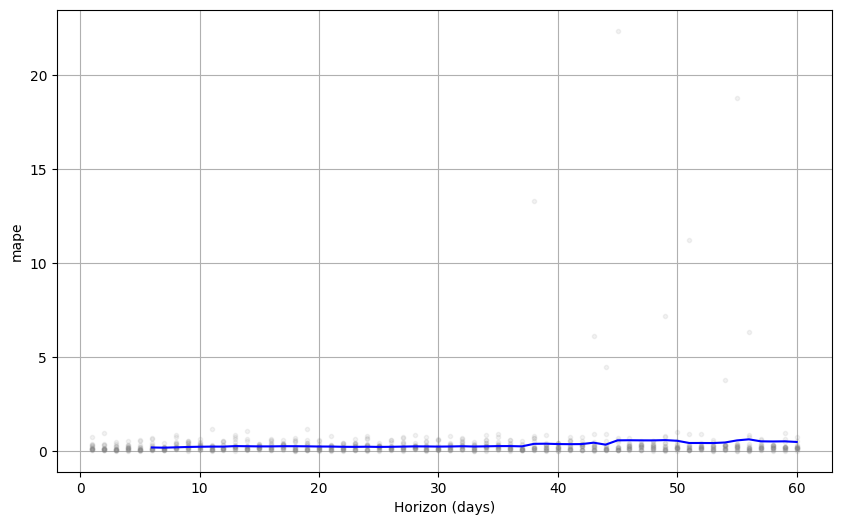

In [76]:
# Execute cross validation
sales_cv = cross_validation(model, initial='365 days', period='90 days', horizon = '60 days')
pm = performance_metrics(sales_cv)
fig = plot_cross_validation_metric(sales_cv, metric='mape')
plt.show()

The MAPE is a measure of the differences between values predicted by a model and the values actually observed. The lower the MAPE, the better the model’s forecasting accuracy. The blue line in the plot represents the average MAPE across all horizons. From this plot, we can observe that the model’s forecasting accuracy is better at shorter horizons and decreases as the horizon increases. However, the average MAPE appears to be relatively stable across all horizons, indicating consistent performance of the model.

This kind of visualization is useful for understanding how well a model performs over time and can help in identifying any potential issues with long-term forecasts. It’s an important tool in model evaluation and selection.

In [79]:
# Now, we can export to a JSON file for resulting in PowerBI
sales_forecast_actual.to_json('Dataset/sales_forecast.json')

In [80]:
# Alternate way to forecast based on product group

result_schema = StructType([
                  StructField('ds', TimestampType()),
                  StructField('y', DoubleType()),
                  StructField('yhat', DoubleType()),
                  StructField('yhat_upper', DoubleType()),
                  StructField('yhat_lower', DoubleType())
])

@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast_sales(data):
  model = Prophet(interval_width=0.95, seasonality_mode= 'multiplicative', weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=True)
  model.fit(data)
  future_pd = model.make_future_dataframe(periods=365, freq='d')
  forecast_pd = model.predict(future_pd)
  f_pd = forecast_pd[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].set_index('ds')
  st_pd = data[['ds', 'y']].set_index('ds')
  result_pd = f_pd.join(st_pd, how='left')
  result_pd.reset_index(level=0, inplace=True)
  return result_pd[['ds', 'y', 'yhat', 'yhat_upper', 'yhat_lower']]